In [13]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

# Define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# List of stock tickers to download
tickers = ['AAPL', 'MSFT', 'NFLX', 'GOOG', 'TSLA']

# Download stock data
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Reset index to bring 'Date' into the columns
data = data.reset_index()

# Flatten the MultiIndex columns by joining with an underscore
data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in data.columns]

# Melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name='Attribute_Ticker', value_name='Value')

# Split the combined 'Attribute_Ticker' column into separate 'Attribute' and 'Ticker' columns
data_melted[['Attribute', 'Ticker']] = data_melted['Attribute_Ticker'].str.split('_', expand=True)

# Pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='Value', aggfunc='first')

# Reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

stock_data.head()


Attribute,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,2023-10-30 00:00:00+00:00,AAPL,169.423035,170.289993,171.169998,168.869995,169.020004,51131000.0
1,2023-10-30 00:00:00+00:00,GOOG,125.441940,125.750000,126.550003,123.879997,124.459999,24165600.0
2,2023-10-30 00:00:00+00:00,MSFT,334.796997,337.309998,339.450012,331.829987,333.410004,22828100.0
3,2023-10-30 00:00:00+00:00,NFLX,410.079987,410.079987,412.820007,399.410004,402.350006,5317100.0
4,2023-10-30 00:00:00+00:00,TSLA,197.360001,197.360001,210.880005,194.669998,209.279999,136448200.0


In [14]:
# convert the 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# set the 'Date' column as the index of the dataframe
stock_data.set_index('Date', inplace=True)
stock_data.head()

Attribute,Ticker,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2023-10-30 00:00:00+00:00,AAPL,169.423035,170.289993,171.169998,168.869995,169.020004,51131000.0
2023-10-30 00:00:00+00:00,GOOG,125.441940,125.750000,126.550003,123.879997,124.459999,24165600.0
2023-10-30 00:00:00+00:00,MSFT,334.796997,337.309998,339.450012,331.829987,333.410004,22828100.0
2023-10-30 00:00:00+00:00,NFLX,410.079987,410.079987,412.820007,399.410004,402.350006,5317100.0
2023-10-30 00:00:00+00:00,TSLA,197.360001,197.360001,210.880005,194.669998,209.279999,136448200.0


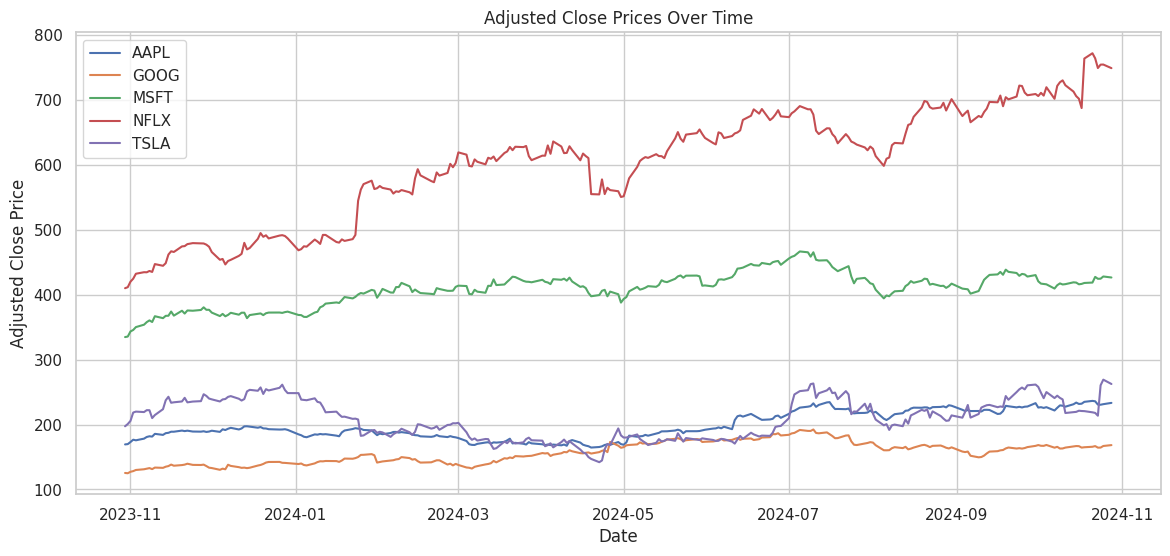

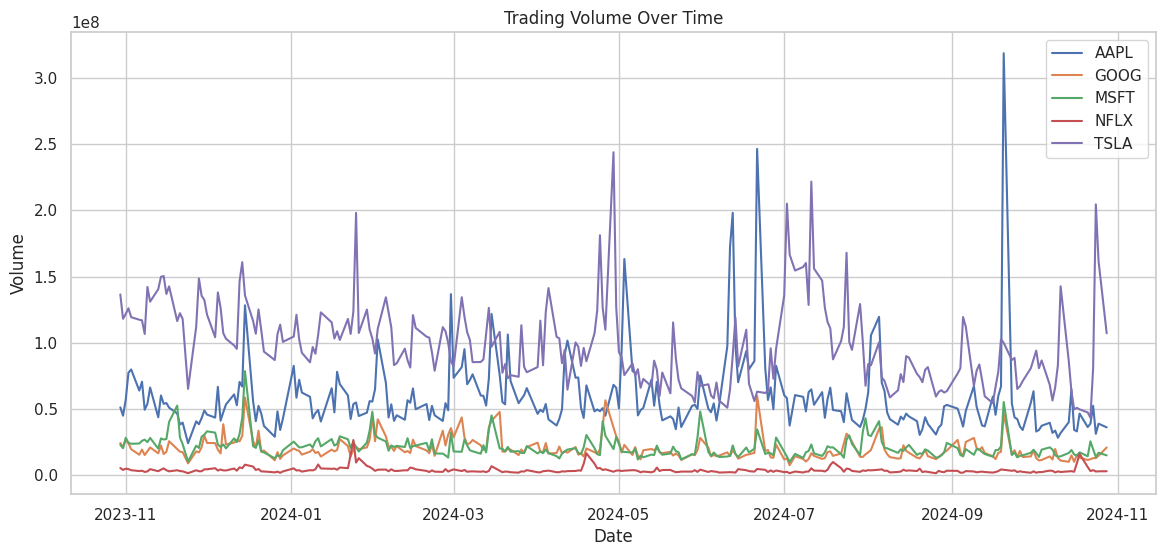

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# plotting the adjusted close prices for each ticker over time
plt.figure(figsize=(14, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Adj Close'], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# plotting the trading volume for each ticker over time
plt.figure(figsize=(14, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Volume'], label=ticker)

plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [19]:
from scipy.stats import zscore

def detect_anomalies(df, column):
    df_copy = df.copy()

    # calculate Z-scores and add them as a new column
    df_copy['Z-score'] = zscore(df_copy[column])

    # find where the absolute Z-score is greater than 2 (common threshold for anomalies)
    anomalies = df_copy[abs(df_copy['Z-score']) > 2]
    return anomalies

anomalies_adj_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()

for ticker in stock_data['Ticker'].unique():
    data_ticker = stock_data[stock_data['Ticker'] == ticker]

    adj_close_anomalies = detect_anomalies(data_ticker, 'Adj Close')
    volume_anomalies = detect_anomalies(data_ticker, 'Volume')

    # use concat instead of append
    anomalies_adj_close = pd.concat([anomalies_adj_close, adj_close_anomalies])
    anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])

    anomalies_adj_close.head()

In [20]:
anomalies_volume.head()

Attribute,Ticker,Adj Close,Close,High,Low,Open,Volume,Z-score
Date,,,,,,,,
2023-12-15 00:00:00+00:00,AAPL,196.823120,197.570007,198.399994,197.000000,197.529999,128256700.0,2.313927
2024-02-29 00:00:00+00:00,AAPL,180.296478,180.750000,182.570007,179.529999,181.270004,136682600.0,2.592701
2024-03-15 00:00:00+00:00,AAPL,172.186874,172.619995,172.619995,170.289993,171.169998,121664700.0,2.095829
2024-05-03 00:00:00+00:00,AAPL,182.919876,183.380005,187.000000,182.660004,186.649994,163224100.0,3.470834
2024-06-11 00:00:00+00:00,AAPL,206.910492,207.149994,207.160004,193.630005,193.649994,172373300.0,3.773538


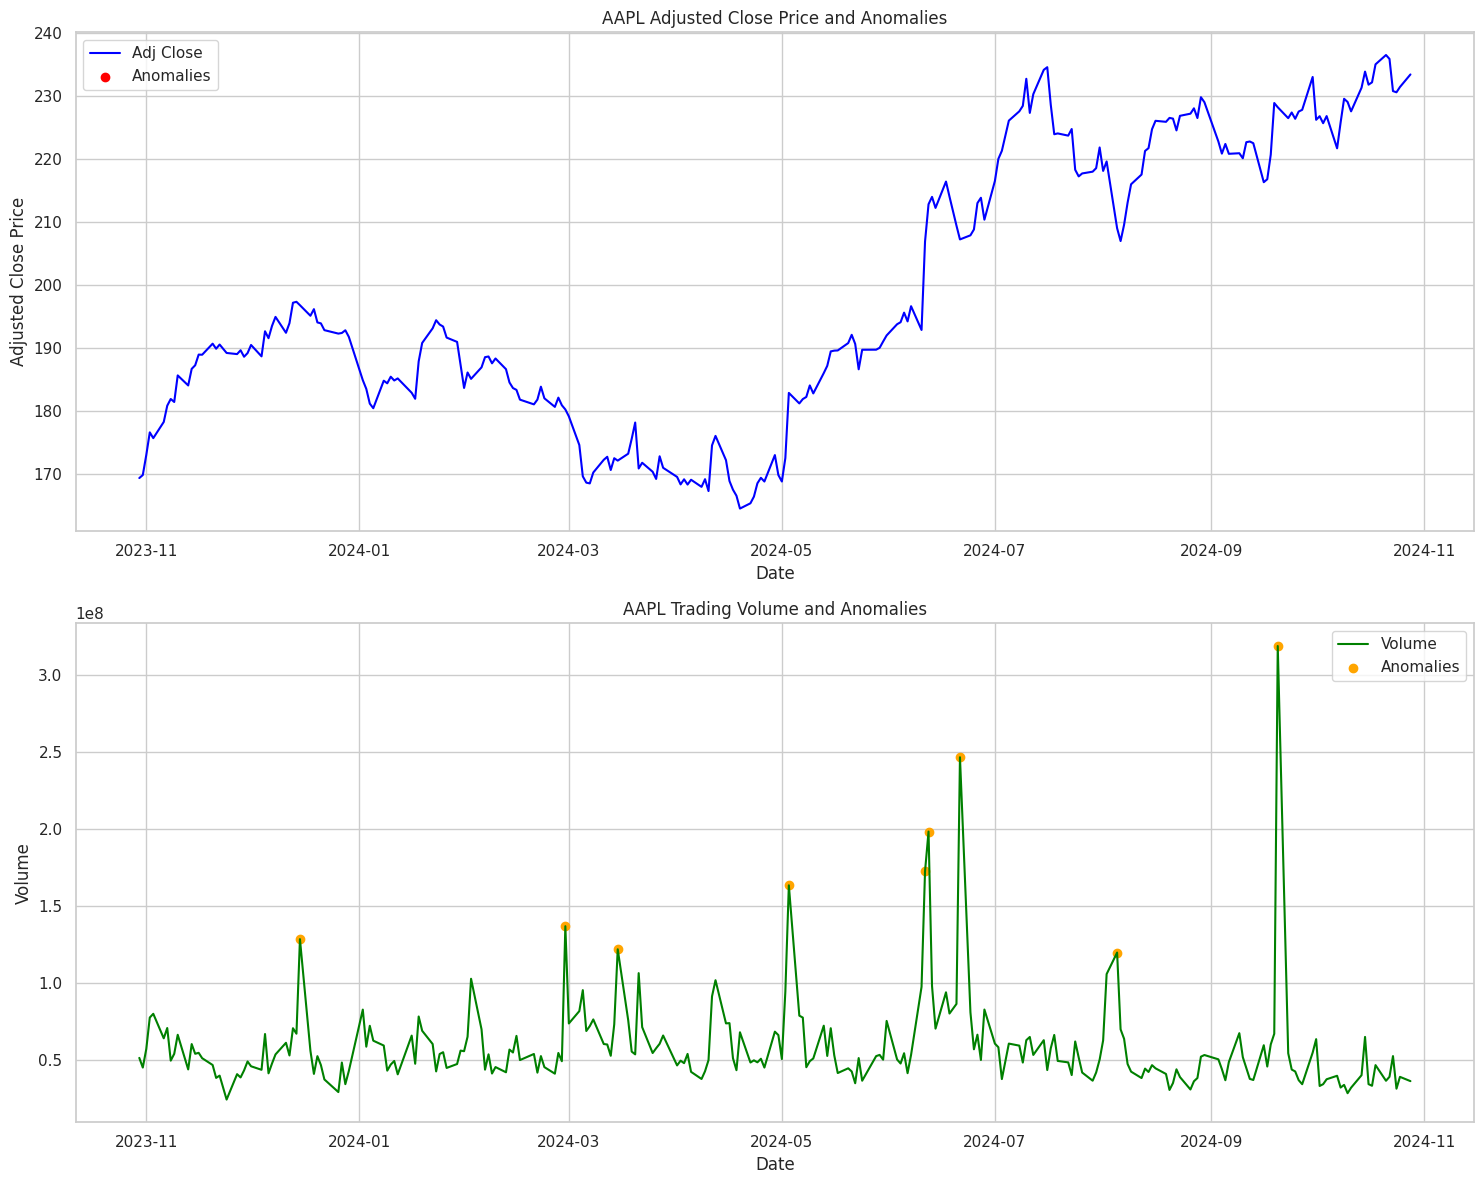

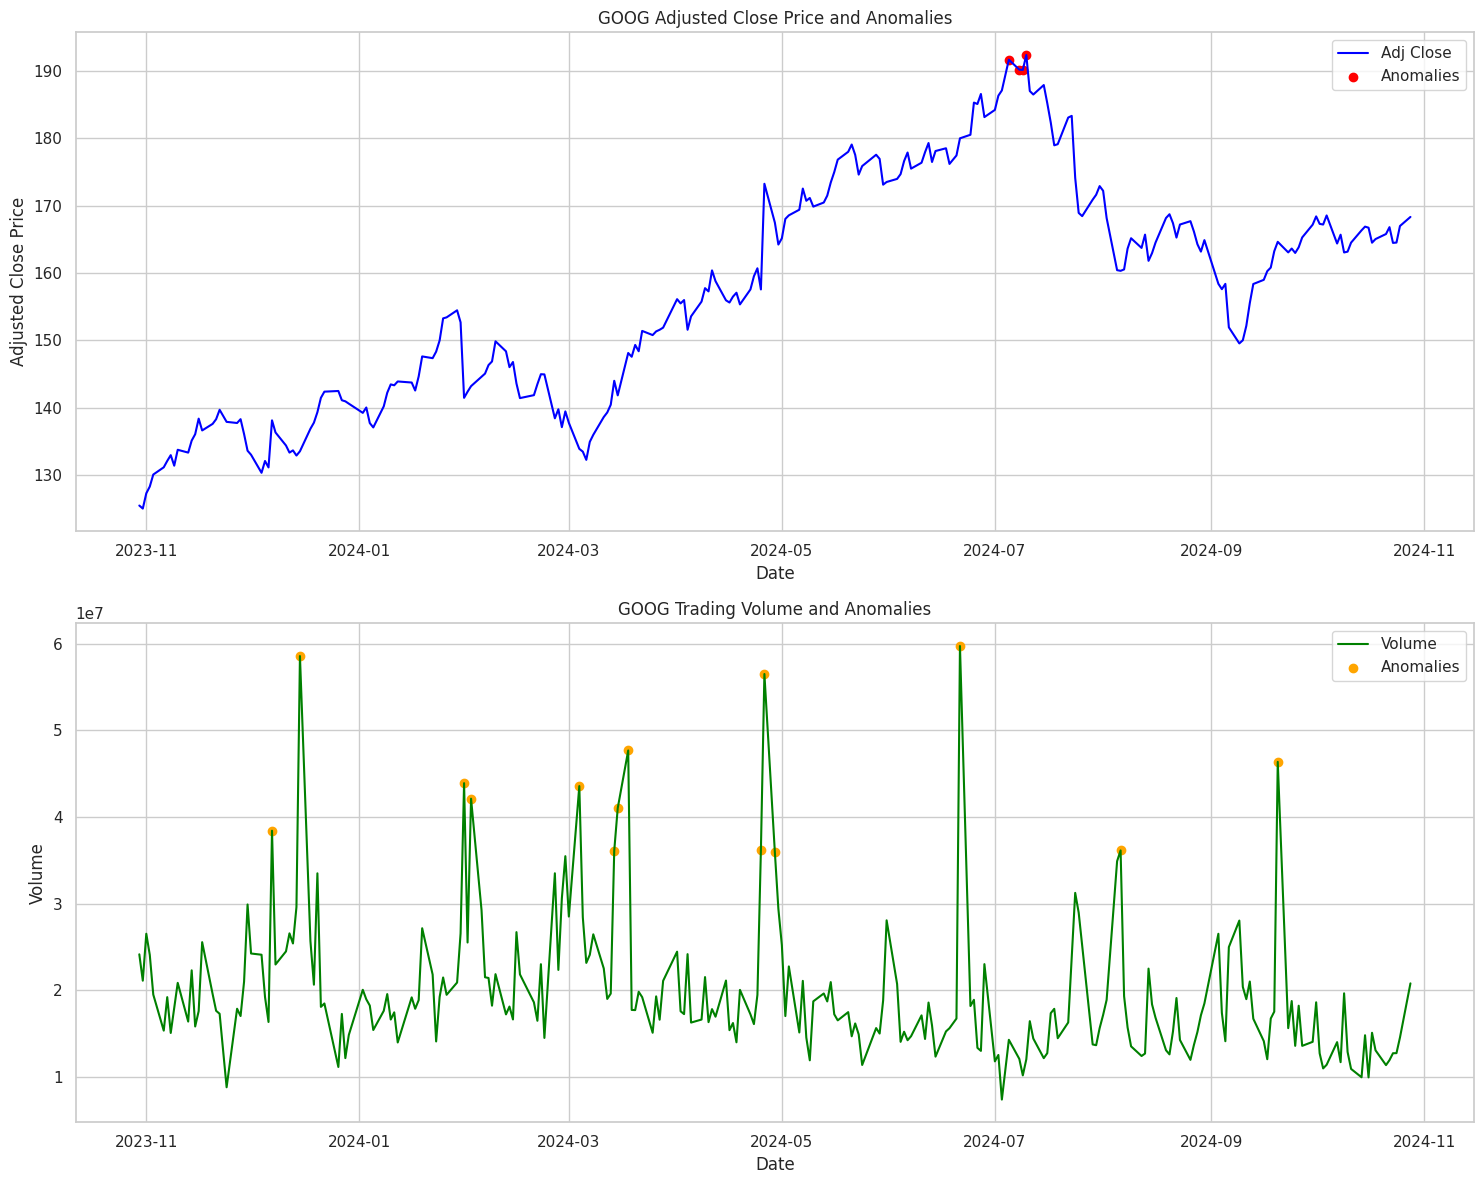

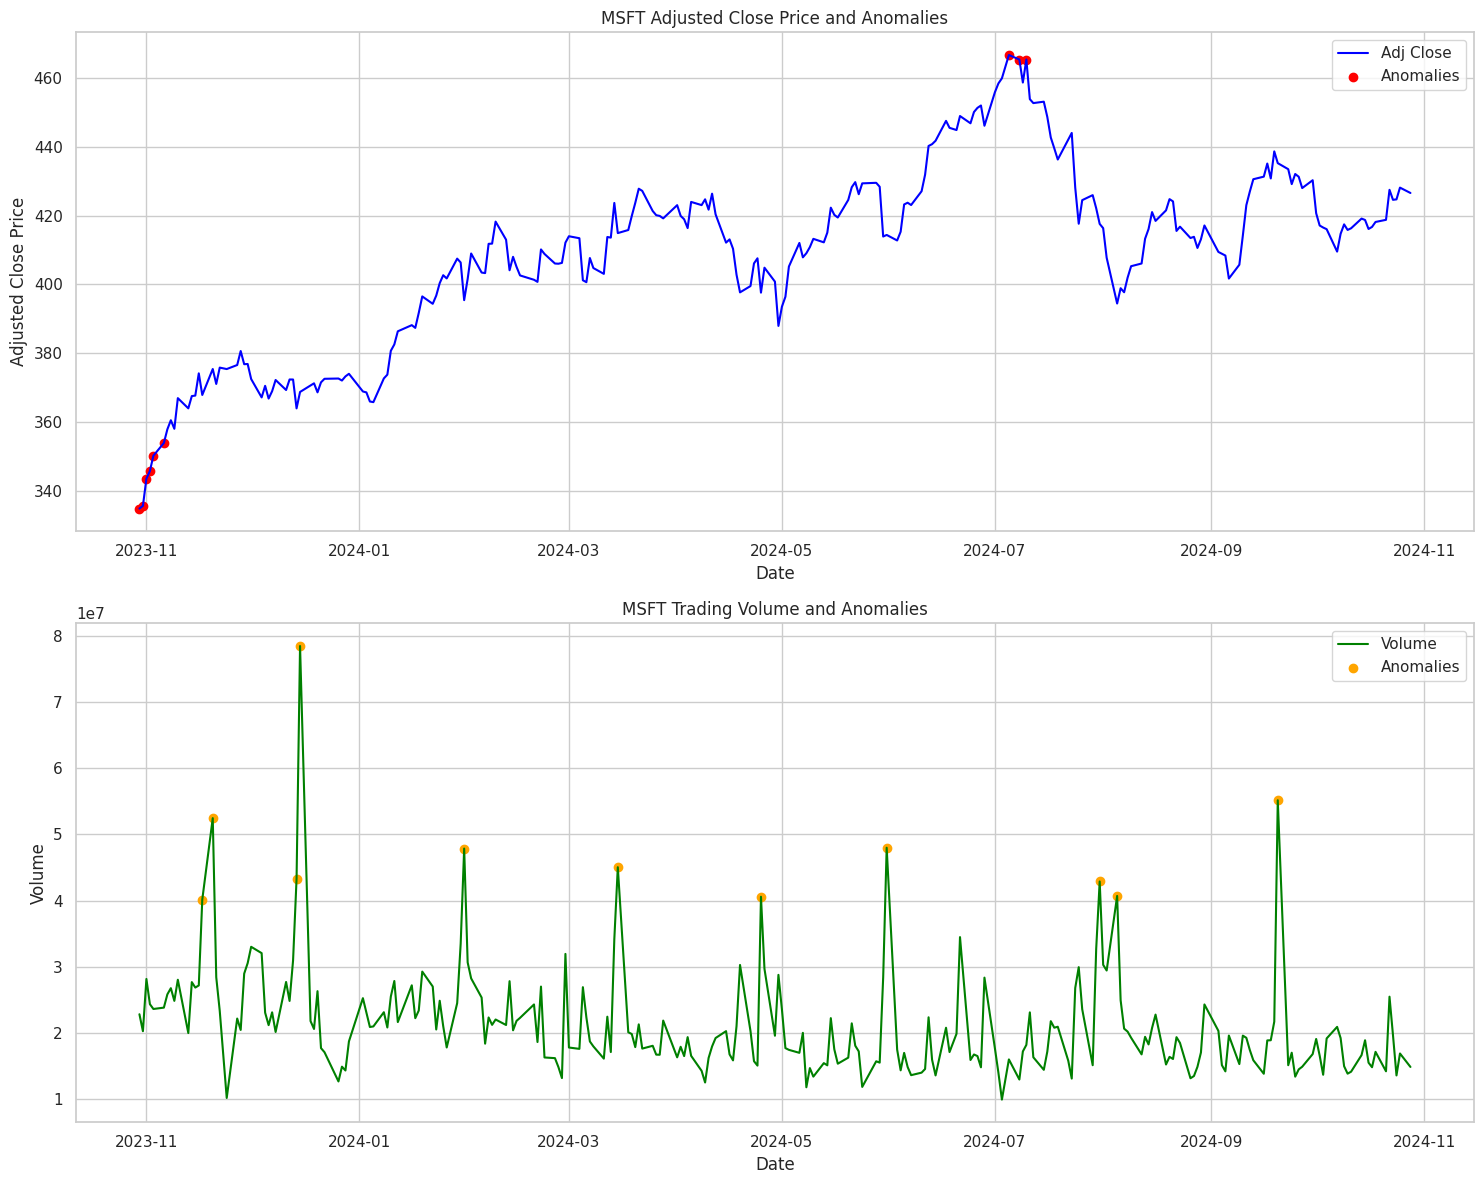

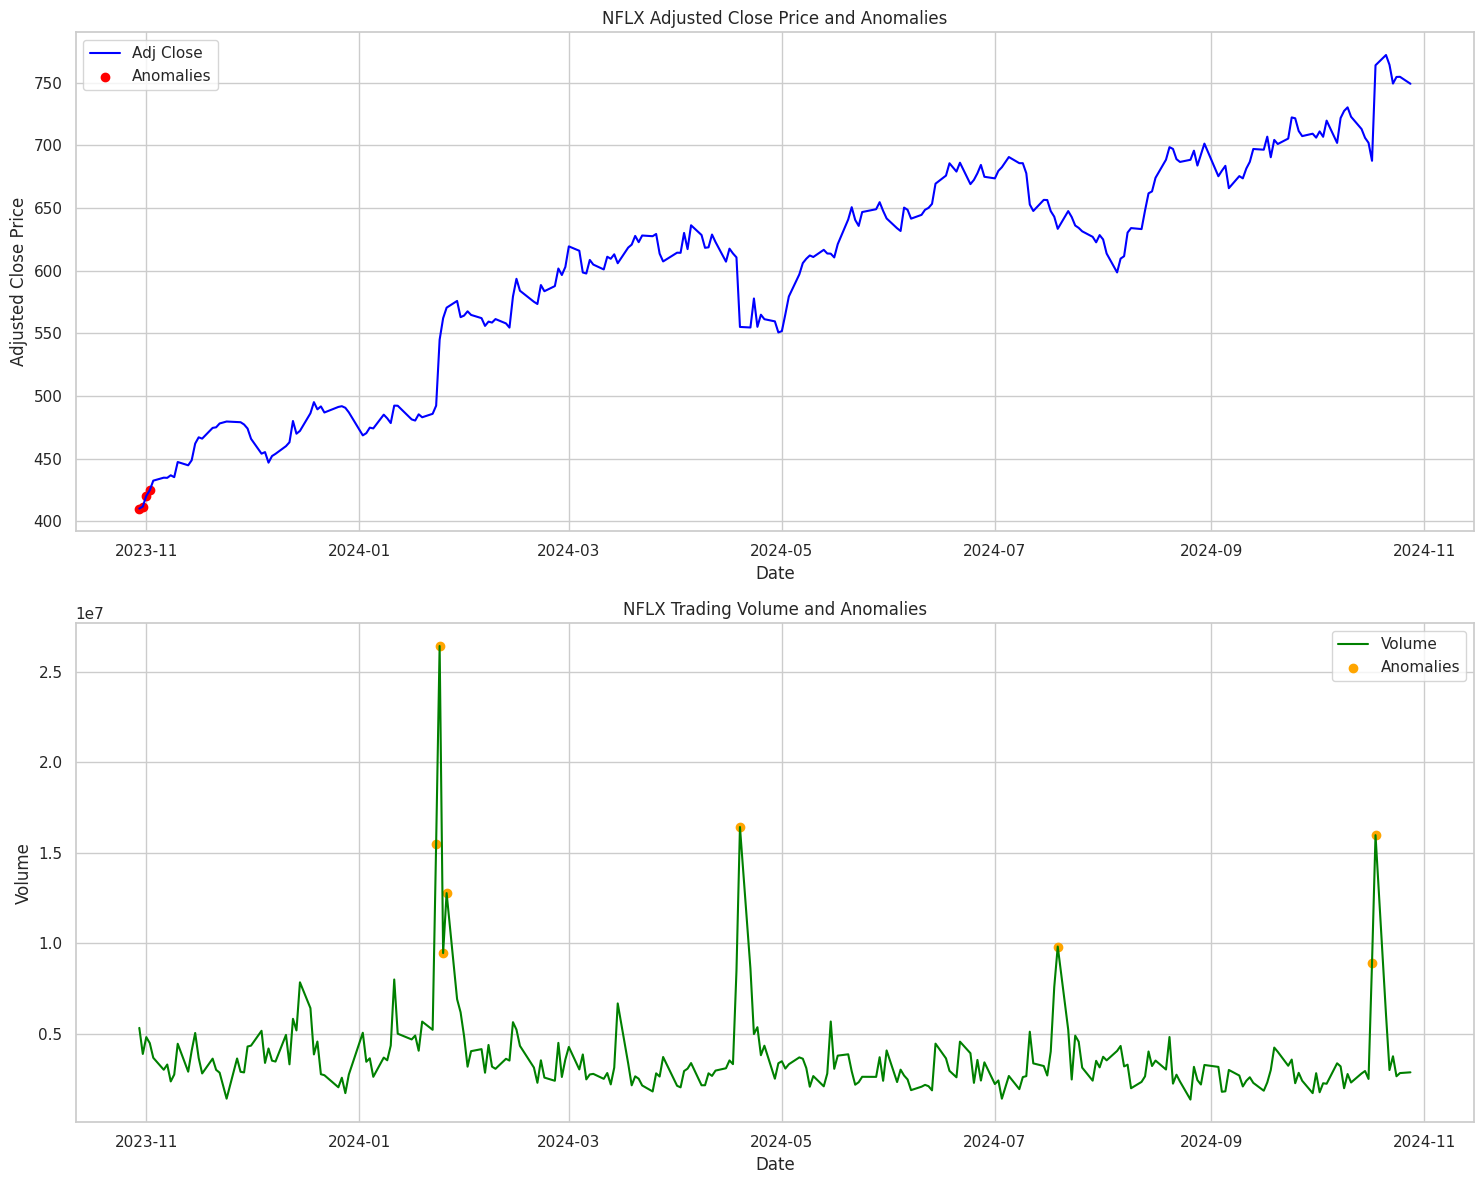

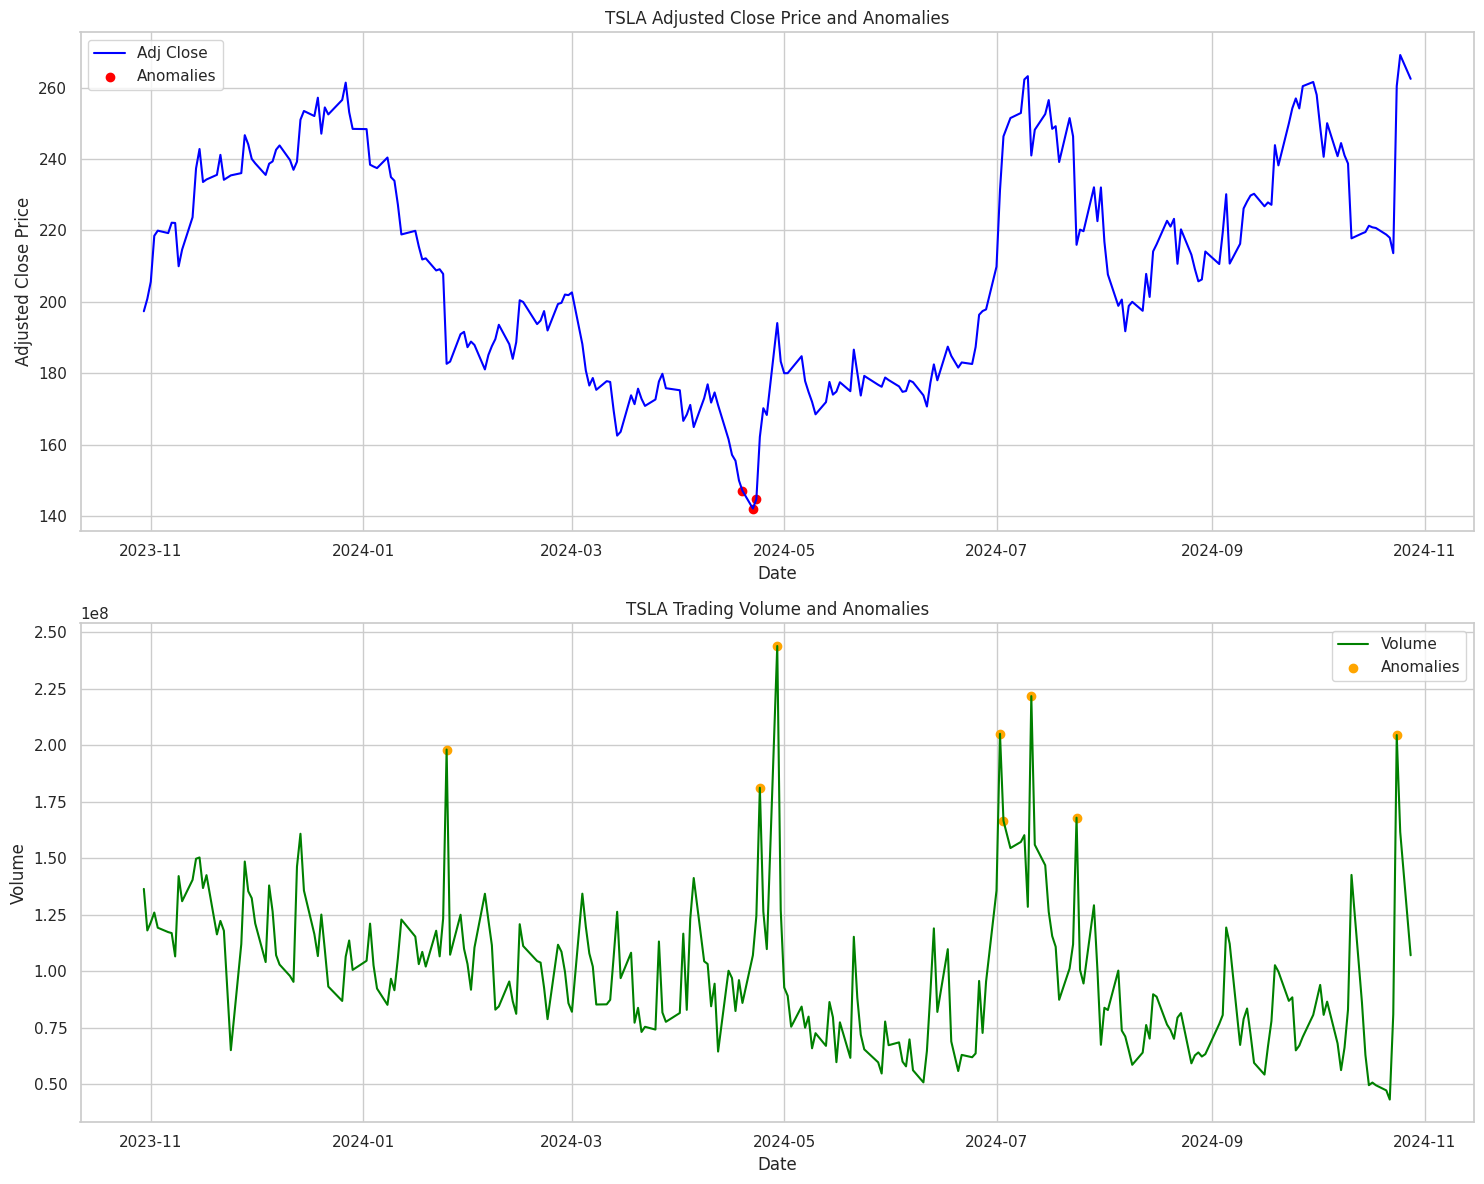

In [10]:
def plot_anomalies(ticker, anomalies_adj_close, anomalies_volume):
    # Filter the main and anomalies data for the given ticker
    data_ticker = stock_data[stock_data['Ticker'] == ticker]
    adj_close_anomalies = anomalies_adj_close[anomalies_adj_close['Ticker'] == ticker]
    volume_anomalies = anomalies_volume[anomalies_volume['Ticker'] == ticker]

    # plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # adjusted close price
    ax1.plot(data_ticker.index, data_ticker['Adj Close'], label='Adj Close', color='blue')
    ax1.scatter(adj_close_anomalies.index, adj_close_anomalies['Adj Close'], color='red', label='Anomalies')
    ax1.set_title(f'{ticker} Adjusted Close Price and Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Close Price')
    ax1.legend()

    # volume
    ax2.plot(data_ticker.index, data_ticker['Volume'], label='Volume', color='green')
    ax2.scatter(volume_anomalies.index, volume_anomalies['Volume'], color='orange', label='Anomalies')
    ax2.set_title(f'{ticker} Trading Volume and Anomalies')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# plot anomalies for each ticker
for ticker in stock_data['Ticker'].unique():
    plot_anomalies(ticker, anomalies_adj_close, anomalies_volume)

In [23]:
# consolidate anomalies for adjusted close prices and volumes
all_anomalies_adj_close = anomalies_adj_close[['Ticker']].copy()
all_anomalies_adj_close['Adj Close Anomaly'] = 1  # indicator variable for anomalies

all_anomalies_volume = anomalies_volume[['Ticker']].copy()
all_anomalies_volume['Volume Anomaly'] = 1  # indicator variable for anomalies

# pivot these dataframes to have one row per date and columns for each ticker, filling non-anomalies with 0
adj_close_pivot = all_anomalies_adj_close.pivot_table(index=all_anomalies_adj_close.index, columns='Ticker',
                                                       fill_value=0, aggfunc='sum')

volume_pivot = all_anomalies_volume.pivot_table(index=all_anomalies_volume.index, columns='Ticker',
                                                fill_value=0, aggfunc='sum')

# flatten the multi-level column index
adj_close_pivot.columns = adj_close_pivot.columns.get_level_values(1)
volume_pivot.columns = volume_pivot.columns.get_level_values(1)

# combine the two pivoted dataframes
combined_anomalies = pd.concat([adj_close_pivot, volume_pivot], axis=1, keys=['Adj Close Anomaly', 'Volume Anomaly'])

# calculate the correlation matrix for the anomalies
correlation_matrix = combined_anomalies.corr()

correlation_matrix

Adj Close Anomaly                                \
Ticker                                GOOG      MSFT      NFLX      TSLA   
                  Ticker                                                   
Adj Close Anomaly GOOG            1.000000  0.083333 -0.444444 -0.365148   
                  MSFT            0.083333  1.000000  0.444444 -0.821584   
                  NFLX           -0.444444  0.444444  1.000000 -0.365148   
                  TSLA           -0.365148 -0.821584 -0.365148  1.000000   
Volume Anomaly    AAPL                 NaN       NaN       NaN       NaN   
                  GOOG                 NaN       NaN       NaN       NaN   
                  MSFT                 NaN       NaN       NaN       NaN   
                  NFLX                 NaN       NaN       NaN       NaN   
                  TSLA                 NaN       NaN       NaN       NaN   

                         Volume Anomaly                                \
Ticker                             AAPL      GOOG      MSFT      NFLX   
                  Ticker                                                
Adj Close Anomaly GOOG              NaN       NaN       NaN       NaN   
                  MSFT              NaN       NaN       NaN       NaN   
                  NFLX              NaN       NaN       NaN       NaN   
                  TSLA              NaN       NaN       NaN       NaN   
Volume Anomaly    AAPL         1.000000  0.087798  0.190361 -0.287678   
                  GOOG         0.087798  1.000000  0.113961 -0.394405   
                  MSFT         0.190361  0.113961  1.000000 -0.329609   
                  NFLX        -0.287678 -0.394405 -0.329609  1.000000   
                  TSLA        -0.287678 -0.260589 -0.329609 -0.108333   

                                    
Ticker                        TSLA  
                  Ticker            
Adj Close Anomaly GOOG         NaN  
                  MSFT         NaN  
                  NFLX         NaN  
                  TSLA         NaN  
Volume Anomaly    AAPL   -0.287678  
                  GOOG   -0.260589  
                  MSFT   -0.329609  
                  NFLX   -0.108333  
                  TSLA    1.000000

In [24]:
# calculate the mean absolute Z-score for each stock as a risk indicator
adj_close_risk = anomalies_adj_close.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())
volume_risk = anomalies_volume.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())

# combine the risk scores from both price and volume anomalies
total_risk = adj_close_risk + volume_risk

# normalize the risk scores to get a relative risk rating from 0 to 1
risk_rating = (total_risk - total_risk.min()) / (total_risk.max() - total_risk.min())

risk_rating

,Z-score
Ticker,
AAPL,NaN
GOOG,0.000000
MSFT,0.526540
NFLX,1.000000
TSLA,0.080325
